# Cell painting data phenotype definition

In this notebook we load the cell painting data (cpg-0016) and create a binary phenotype definition.

In [1]:
# Setup and imports
import numpy as np
import pandas as pd
import dask.dataframe as dd
from scipy.stats import gaussian_kde
import seaborn as sns
import matplotlib.pyplot as plt
import pycytominer
%matplotlib inline

In [2]:
# Template for loading profiles
profile_uri_template = (
    "s3://cellpainting-gallery/cpg0016-jump/"
    "{Metadata_Source}/workspace/profiles/"
    "{Metadata_Batch}/{Metadata_Plate}/{Metadata_Plate}.parquet"
)

In [3]:
# Load metadata
plates = pd.read_csv("datasets/metadata/plate.csv.gz")
wells = pd.read_csv("datasets/metadata/well.csv.gz")
orf = pd.read_csv("datasets/metadata/orf.csv.gz")
crispr = pd.read_csv("datasets/metadata/crispr.csv.gz", dtype={'Metadata_NCBI_Gene_ID': 'str'})
compound = pd.read_csv("datasets/metadata/compound.csv.gz")

In [4]:
plates.Metadata_PlateType.value_counts()

Metadata_PlateType
COMPOUND          1729
ORF                251
CRISPR             148
TARGET2            141
DMSO                77
COMPOUND_EMPTY      20
POSCON8              8
TARGET1              4
Name: count, dtype: int64

Wells (and profiles) are identified by their `Metadata_{Source, Plate, Well}` triple.

We need to attach metadata about the genetic perturbation to each well.

In [5]:
orf

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,Metadata_Insert_Length,Metadata_pert_type
0,JCP2022_900002,ccsbBroad304_00001,ORF008415.1_TRC304.1,pLX_304,NM_001160173.3,NAT1,9,9606,N-acetyltransferase 1,100.0,870.0,trt
1,JCP2022_900003,ccsbBroad304_00002,ORF005388.1_TRC304.1,pLX_304,NM_001088.3,AANAT,15,9606,aralkylamine N-acetyltransferase,100.0,621.0,trt
2,JCP2022_900004,ccsbBroad304_00003,ORF003876.1_TRC304.1,pLX_304,NM_000663.4,ABAT,18,9606,4-aminobutyrate aminotransferase,100.0,1500.0,trt
3,JCP2022_900005,ccsbBroad304_00007,ORF004679.1_TRC304.1,pLX_304,NM_000018.4,ACADVL,37,9606,acyl-CoA dehydrogenase very long chain,100.0,1965.0,trt
4,JCP2022_900006,ccsbBroad304_00008,ORF000425.1_TRC304.1,pLX_304,NM_001095.4,ASIC1,41,9606,acid sensing ion channel subunit 1,100.0,1584.0,trt
...,...,...,...,...,...,...,...,...,...,...,...,...
15137,JCP2022_915128,ccsbBroad304_99985,ORFC00001.1_TRC304.1,pLX_304,BFP.1,BFP,BFP,CONTROL,Hahn Lab BFP,99.5,717.0,negcon
15138,JCP2022_915129,ccsbBroad304_99988,ORFC00002.1_TRC304.1,pLX_304,HcRed.1,HcRed,HcRed,CONTROL,NaN,NaN,824.0,negcon
15139,JCP2022_915130,ccsbBroad304_99991,ORFC00003.1_TRC304.1,pLX_304,promegaLuc.1,LUCIFERASE,LUCIFERASE,CONTROL,promegaLuc,100.0,1650.0,negcon
15140,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,3204.0,negcon


For ORF perturbations we keep the gene ID, Symbol, and prepend a string to treatment to identify that it's an ORF perturbation

In [6]:
orf_meta = orf[['Metadata_JCP2022', 'Metadata_Symbol', 'Metadata_NCBI_Gene_ID']]
orf_meta['Metadata_Perturbation'] = orf.Metadata_pert_type.apply(lambda x: f'ORF-{x}')
orf_meta

/tmp/ipykernel_892347/3138304948.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orf_meta['Metadata_Perturbation'] = orf.Metadata_pert_type.apply(lambda x: f'ORF-{x}')


,Metadata_JCP2022,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Perturbation
0,JCP2022_900002,NAT1,9,ORF-trt
1,JCP2022_900003,AANAT,15,ORF-trt
2,JCP2022_900004,ABAT,18,ORF-trt
3,JCP2022_900005,ACADVL,37,ORF-trt
4,JCP2022_900006,ASIC1,41,ORF-trt
...,...,...,...,...
15137,JCP2022_915128,BFP,BFP,ORF-negcon
15138,JCP2022_915129,HcRed,HcRed,ORF-negcon
15139,JCP2022_915130,LUCIFERASE,LUCIFERASE,ORF-negcon
15140,JCP2022_915131,LacZ,LacZ,ORF-negcon


In [7]:
orf_meta[orf_meta.Metadata_Perturbation == 'ORF-poscon']

,Metadata_JCP2022,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Perturbation
15141,JCP2022_915132,eGFP,eGFP,ORF-poscon


In [8]:
orf_meta.Metadata_Perturbation.value_counts()

Metadata_Perturbation
ORF-trt       15137
ORF-negcon        4
ORF-poscon        1
Name: count, dtype: int64

In [9]:
crispr

,Metadata_JCP2022,Metadata_NCBI_Gene_ID,Metadata_Symbol
0,JCP2022_800001,NaN,no-guide
1,JCP2022_800002,NaN,non-targeting
2,JCP2022_800003,2,A2M
3,JCP2022_800004,127550,A3GALT2
4,JCP2022_800005,53947,A4GALT
...,...,...,...
7972,JCP2022_807973,54925,ZSCAN32
7973,JCP2022_807974,201516,ZSCAN4
7974,JCP2022_807975,79149,ZSCAN5A
7975,JCP2022_807976,7746,ZSCAN9


For CRISPR perturbations we keep the gene ID and Symbol, and infer the perturbation type. 

In [10]:
crispr_meta = crispr
crispr_meta['Metadata_Perturbation'] = crispr.Metadata_Symbol.apply(lambda x : f'CRISPR-{x}' if x in {'no-guide', 'non-targeting'} else 'CRISPR-trt')
crispr_meta

,Metadata_JCP2022,Metadata_NCBI_Gene_ID,Metadata_Symbol,Metadata_Perturbation
0,JCP2022_800001,NaN,no-guide,CRISPR-no-guide
1,JCP2022_800002,NaN,non-targeting,CRISPR-non-targeting
2,JCP2022_800003,2,A2M,CRISPR-trt
3,JCP2022_800004,127550,A3GALT2,CRISPR-trt
4,JCP2022_800005,53947,A4GALT,CRISPR-trt
...,...,...,...,...
7972,JCP2022_807973,54925,ZSCAN32,CRISPR-trt
7973,JCP2022_807974,201516,ZSCAN4,CRISPR-trt
7974,JCP2022_807975,79149,ZSCAN5A,CRISPR-trt
7975,JCP2022_807976,7746,ZSCAN9,CRISPR-trt


In [11]:
crispr_meta.Metadata_Perturbation.value_counts()

Metadata_Perturbation
CRISPR-trt              7975
CRISPR-no-guide            1
CRISPR-non-targeting       1
Name: count, dtype: int64

In [12]:
compound

,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI
0,JCP2022_000001,AAAHWCWPZPSPIW-UHFFFAOYSA-N,InChI=1S/C25H31N5O2/c1-4-23-26-14-16-30(23)24-...
1,JCP2022_000002,AAAJHRMBUHXWLD-UHFFFAOYSA-N,InChI=1S/C11H13ClN2O/c12-10-4-2-9(3-5-10)8-14-...
2,JCP2022_000003,AAALVYBICLMAMA-UHFFFAOYSA-N,InChI=1S/C20H15N3O2/c24-19-15-11-17(21-13-7-3-...
3,JCP2022_000004,AAANUZMCJQUYNX-UHFFFAOYSA-N,InChI=1S/C13H22N4O2S/c1-2-7-16-13(5-6-15-16)20...
4,JCP2022_000005,AAAQFGUYHFJNHI-UHFFFAOYSA-N,InChI=1S/C22H22ClN5O2/c1-4-24-20(29)12-18-22-2...
...,...,...,...
116748,JCP2022_116750,ZZZTXDPKNAOZPM-UHFFFAOYSA-N,InChI=1S/C22H27N3O2/c1-14-18(22(27)24-15(2)23-...
116749,JCP2022_116751,ZZZUOLMMTJKOGE-UHFFFAOYSA-N,InChI=1S/C19H17N5O2/c1-23-9-6-13-7-10-24(19(26...
116750,JCP2022_116752,ZZZZIBSVRUABIA-UHFFFAOYSA-N,InChI=1S/C19H13F6N3O2S/c1-11-26-6-5-17(27-11)1...
116751,JCP2022_116753,ZZZZVNLQWWXZTQ-UHFFFAOYSA-N,InChI=1S/C14H20N2O3/c1-18-13-5-3-2-4-12(13)14(...


For compounds, we'll keep track of whether there's a compound perturbation or untreated. We'll also put the InChIKey in the Symbol column.

In [13]:
compound_meta = compound[['Metadata_JCP2022', 'Metadata_InChIKey']]
compound_meta['Metadata_Perturbation'] = 'Compound-trt'
compound_meta['Metadata_Perturbation'][compound_meta.Metadata_InChIKey.isna()] = 'Untreated'
compound_meta.rename(columns={'Metadata_InChIKey': 'Metadata_Symbol'}, inplace=True)
compound_meta

,Metadata_JCP2022,Metadata_Symbol,Metadata_Perturbation
0,JCP2022_000001,AAAHWCWPZPSPIW-UHFFFAOYSA-N,Compound-trt
1,JCP2022_000002,AAAJHRMBUHXWLD-UHFFFAOYSA-N,Compound-trt
2,JCP2022_000003,AAALVYBICLMAMA-UHFFFAOYSA-N,Compound-trt
3,JCP2022_000004,AAANUZMCJQUYNX-UHFFFAOYSA-N,Compound-trt
4,JCP2022_000005,AAAQFGUYHFJNHI-UHFFFAOYSA-N,Compound-trt
...,...,...,...
116748,JCP2022_116750,ZZZTXDPKNAOZPM-UHFFFAOYSA-N,Compound-trt
116749,JCP2022_116751,ZZZUOLMMTJKOGE-UHFFFAOYSA-N,Compound-trt
116750,JCP2022_116752,ZZZZIBSVRUABIA-UHFFFAOYSA-N,Compound-trt
116751,JCP2022_116753,ZZZZVNLQWWXZTQ-UHFFFAOYSA-N,Compound-trt


Create a common table for all genetic perturbations

In [14]:
common_meta = pd.concat([orf_meta, crispr_meta, compound_meta], ignore_index=True)

In [15]:
common_meta.Metadata_Perturbation.value_counts()

Metadata_Perturbation
Compound-trt            116752
ORF-trt                  15137
CRISPR-trt                7975
ORF-negcon                   4
ORF-poscon                   1
CRISPR-no-guide              1
CRISPR-non-targeting         1
Untreated                    1
Name: count, dtype: int64

## Identifying control wells

We want to figure out how many control wells we have

In [16]:
control_conditions = common_meta[common_meta.Metadata_Perturbation.isin({'ORF-negcon', 'ORF-poscon', 'CRISPR-no-guide', 'CRISPR-non-targeting', 'Untreated'})]
control_conditions

,Metadata_JCP2022,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Perturbation
15137,JCP2022_915128,BFP,BFP,ORF-negcon
15138,JCP2022_915129,HcRed,HcRed,ORF-negcon
15139,JCP2022_915130,LUCIFERASE,LUCIFERASE,ORF-negcon
15140,JCP2022_915131,LacZ,LacZ,ORF-negcon
15141,JCP2022_915132,eGFP,eGFP,ORF-poscon
15142,JCP2022_800001,no-guide,NaN,CRISPR-no-guide
15143,JCP2022_800002,non-targeting,NaN,CRISPR-non-targeting
139871,JCP2022_999999,NaN,NaN,Untreated


In [17]:
control_wells = wells.merge(control_conditions, how='right', on=['Metadata_JCP2022'])
control_wells.groupby(['Metadata_Perturbation']).count()

,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Symbol,Metadata_NCBI_Gene_ID
Metadata_Perturbation,,,,,,
CRISPR-no-guide,4724,4724,4724,4724,4724,0
CRISPR-non-targeting,2754,2754,2754,2754,2754,0
ORF-negcon,3892,3892,3892,3892,3892,3892
ORF-poscon,2026,2026,2026,2026,2026,2026
Untreated,37094,37094,37094,37094,0,0


In [18]:
control_wells.groupby(['Metadata_Perturbation']).Metadata_Plate.unique().map(len)

Metadata_Perturbation
CRISPR-no-guide         148
CRISPR-non-targeting    148
ORF-negcon              237
ORF-poscon              237
Untreated               702
Name: Metadata_Plate, dtype: int64

### Load CRISPR plates

In [19]:
# Load profiles
crispr_set = plates[plates.Metadata_PlateType == 'CRISPR']
profiles = dd.read_parquet(
    [profile_uri_template.format_map(row) for _, row in crispr_set.iterrows()],
    storage_options={"anon": True}
)

In [20]:
annotated_wells = wells.merge(common_meta, how='left', on=['Metadata_JCP2022'])

In [21]:
# Merge with  metadata
annotated_profiles = profiles.merge(annotated_wells, how='left', on=['Metadata_Source', 'Metadata_Plate', 'Metadata_Well']).compute()

In [22]:
# Identify feature columns
numeric_profiles = annotated_profiles.select_dtypes(include='number')
feature_cols = numeric_profiles.columns[~numeric_profiles.columns.str.startswith('Metadata') & ~numeric_profiles.isna().any()]

In [23]:
# Get normalized profiles
normalized_profiles = annotated_profiles.groupby('Metadata_Plate').apply(
    pycytominer.normalize,
    # profiles is first positional argument
    features=list(feature_cols),
    image_features=True, # Include Image_### features
    method="standardize",
    samples="Metadata_Perturbation == 'CRISPR-no-guide'"
)

In [24]:
normalized_profiles.to_parquet('data/cpg0016/normalized_profiles')

### Phenotype definition

In [25]:
# Get SD counts
profiles_sd2 = (normalized_profiles[feature_cols].abs() > 2).sum(axis='columns')

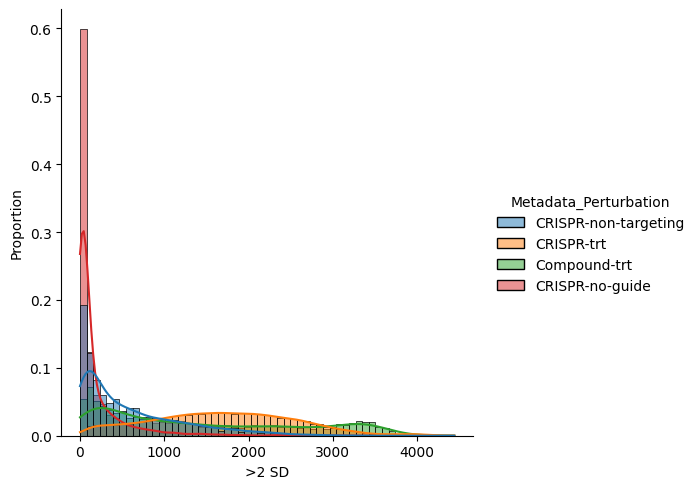

In [26]:
annotated_sd2 = normalized_profiles[['Metadata_Perturbation', 'Metadata_Plate']].copy()
annotated_sd2['>2 SD'] = profiles_sd2

sns.displot(
    data=annotated_sd2,
    x='>2 SD',
    hue='Metadata_Perturbation',
    kde=True,
    common_norm=False,
    stat='proportion'
)

We define our thresholds based on the counts of features that are greater than 2 standard deviations from the mean.

* A positive label (representing morphological change) is given to counts above the point where the `CRISPR-trt` density surpasses 5 times the `CRISPR-no-guide` (control) density.
* A negative label (representing the absence of morphological change) is given to counts below the point where the `CRISPR-no-guide` density surpasses the the `CRISPR-trt` density.

In [27]:
control_kde = gaussian_kde(
    dataset = profiles_sd2[annotated_sd2['Metadata_Perturbation'] == 'CRISPR-no-guide'],
    bw_method='scott'
)

In [28]:
crispr_kde = gaussian_kde(
    dataset = profiles_sd2[annotated_sd2['Metadata_Perturbation'] == 'CRISPR-trt'],
    bw_method='scott'
)

In [29]:
range_array = np.arange(len(feature_cols))
pt = np.where(control_kde(range_array)*5 < crispr_kde(range_array))[0][0]
nt = np.where(control_kde(range_array) < crispr_kde(range_array)*1)[0][0]

pt, nt

(990, 541)

In [30]:
labeled_df = annotated_sd2.copy()
labeled_df['label'] = 'Indeterminate'
labeled_df.loc[profiles_sd2 >= pt, 'label'] = 'Positive'
labeled_df.loc[profiles_sd2 <= nt, 'label'] = 'Negative'
labeled_df[['Metadata_Perturbation', 'label']].value_counts().sort_index()

Metadata_Perturbation  label        
CRISPR-no-guide        Indeterminate      272
                       Negative          4268
                       Positive           184
CRISPR-non-targeting   Indeterminate      502
                       Negative          1633
                       Positive           619
CRISPR-trt             Indeterminate     5243
                       Negative          4384
                       Positive         34080
Compound-trt           Indeterminate      788
                       Negative          1836
                       Positive          3012
Name: count, dtype: int64

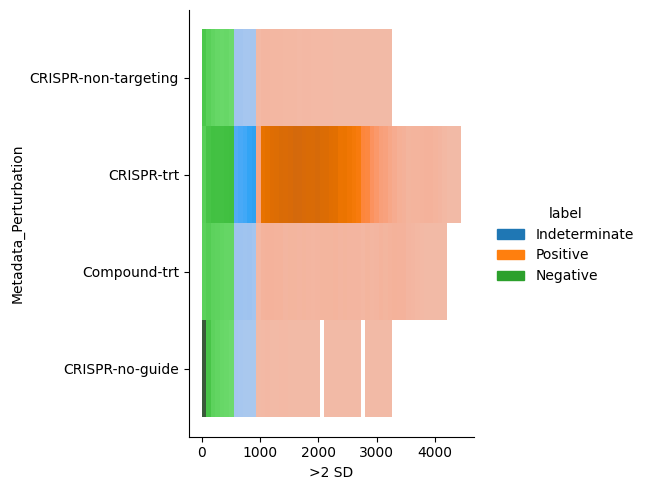

In [31]:
sns.displot(
    data=labeled_df,
    y='Metadata_Perturbation',
    x='>2 SD',
    hue='label',
    #kind='kde'
)

### Linking well levels to CRISPR KOs

In [32]:
labeled_metadata = pd.concat(
    [
        labeled_df.reset_index('Metadata_Plate', drop=True)['label'],
        annotated_profiles[
            annotated_profiles.columns[
                annotated_profiles.columns.str.startswith('Metadata')
            ]
        ]
    ],
    axis='columns'
)

In [33]:
# Deliverable #1: Labeled wells
labeled_metadata.to_csv('data/well_labels.csv', index=False)

In [34]:
labeled_crispr_trt = labeled_metadata[labeled_metadata['Metadata_Perturbation'] == 'CRISPR-trt']

labeled_crispr_genes = (
    labeled_crispr_trt
    .groupby(['Metadata_Symbol', 'Metadata_NCBI_Gene_ID'])
    .label
    .value_counts()
    .unstack('label', fill_value=0)
)
labeled_crispr_genes

,label,Indeterminate,Negative,Positive
Metadata_Symbol,Metadata_NCBI_Gene_ID,,,
A2M,2,1,1,3
A3GALT2,127550,1,0,4
A4GALT,53947,0,0,5
A4GNT,51146,3,0,3
AACS,65985,1,0,4
...,...,...,...,...
ZSCAN32,54925,4,0,1
ZSCAN4,201516,0,0,3
ZSCAN5A,79149,0,0,5


We need a rule to find "surely positive" and "surely negative" genes.
The approach we will take is to label by the majority.

In [35]:
pls = labeled_crispr_genes['Positive']
nls = labeled_crispr_genes['Negative']
ils = labeled_crispr_genes['Indeterminate']

final_labeled_crispr_genes = labeled_crispr_genes.copy()
final_labeled_crispr_genes['gene_label'] = 'Indeterminate'
final_labeled_crispr_genes['gene_label'][pls > nls + ils] = 'Positive'
final_labeled_crispr_genes['gene_label'][nls > pls + ils] = 'Negative'

final_labeled_crispr_genes.gene_label.value_counts()

/tmp/ipykernel_892347/3743650821.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_labeled_crispr_genes['gene_label'][pls > nls + ils] = 'Positive'
/tmp/ipykernel_892347/3743650821.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_labeled_crispr_genes['gene_label'][nls > pls + ils] = 'Negative'


gene_label
Positive         6649
Indeterminate     979
Negative          347
Name: count, dtype: int64

In [36]:
# Deliverable #2: gene labels
final_labeled_crispr_genes.to_csv('data/gene_labels.csv')

### Defining per-channel phenotypes

In [37]:
# Defining per-channel columns

# The channels are
channels = ['Mito', 'ER', 'RNA', 'AGP', 'DNA']

feature_channels = pd.DataFrame(
    data={
        channel: feature_cols.str.contains(channel)
        for channel in channels
    },
    index=feature_cols
)

feature_channels['Count'] = feature_channels.sum(axis='columns')

feature_channels

,Mito,ER,RNA,AGP,DNA,Count
Cells_AreaShape_Area,False,False,False,False,False,0
Cells_AreaShape_BoundingBoxArea,False,False,False,False,False,0
Cells_AreaShape_BoundingBoxMaximum_X,False,False,False,False,False,0
Cells_AreaShape_BoundingBoxMaximum_Y,False,False,False,False,False,0
Cells_AreaShape_BoundingBoxMinimum_X,False,False,False,False,False,0
...,...,...,...,...,...,...
Nuclei_Texture_Variance_RNA_3_03_256,False,False,True,False,False,1
Nuclei_Texture_Variance_RNA_5_00_256,False,False,True,False,False,1
Nuclei_Texture_Variance_RNA_5_01_256,False,False,True,False,False,1
Nuclei_Texture_Variance_RNA_5_02_256,False,False,True,False,False,1


In [38]:
# Here we narrow down to features that refer to exactly one channel.

exclusive_channels = feature_channels[feature_channels.Count == 1]

In [40]:
# Get SD counts
annotated_channel_sd2 = pd.concat(
    [
        normalized_profiles[['Metadata_Perturbation']]
    ] + [
        (normalized_profiles[exclusive_channels.index[exclusive_channels[channel]]].abs() > 2).sum(axis='columns').to_frame(name=channel)
        for channel in channels
    ],
    axis='columns'
)

In [41]:
long_annotated_channel_sd2 = annotated_channel_sd2.melt(id_vars='Metadata_Perturbation', value_vars=channels, var_name='channel', ignore_index=False)

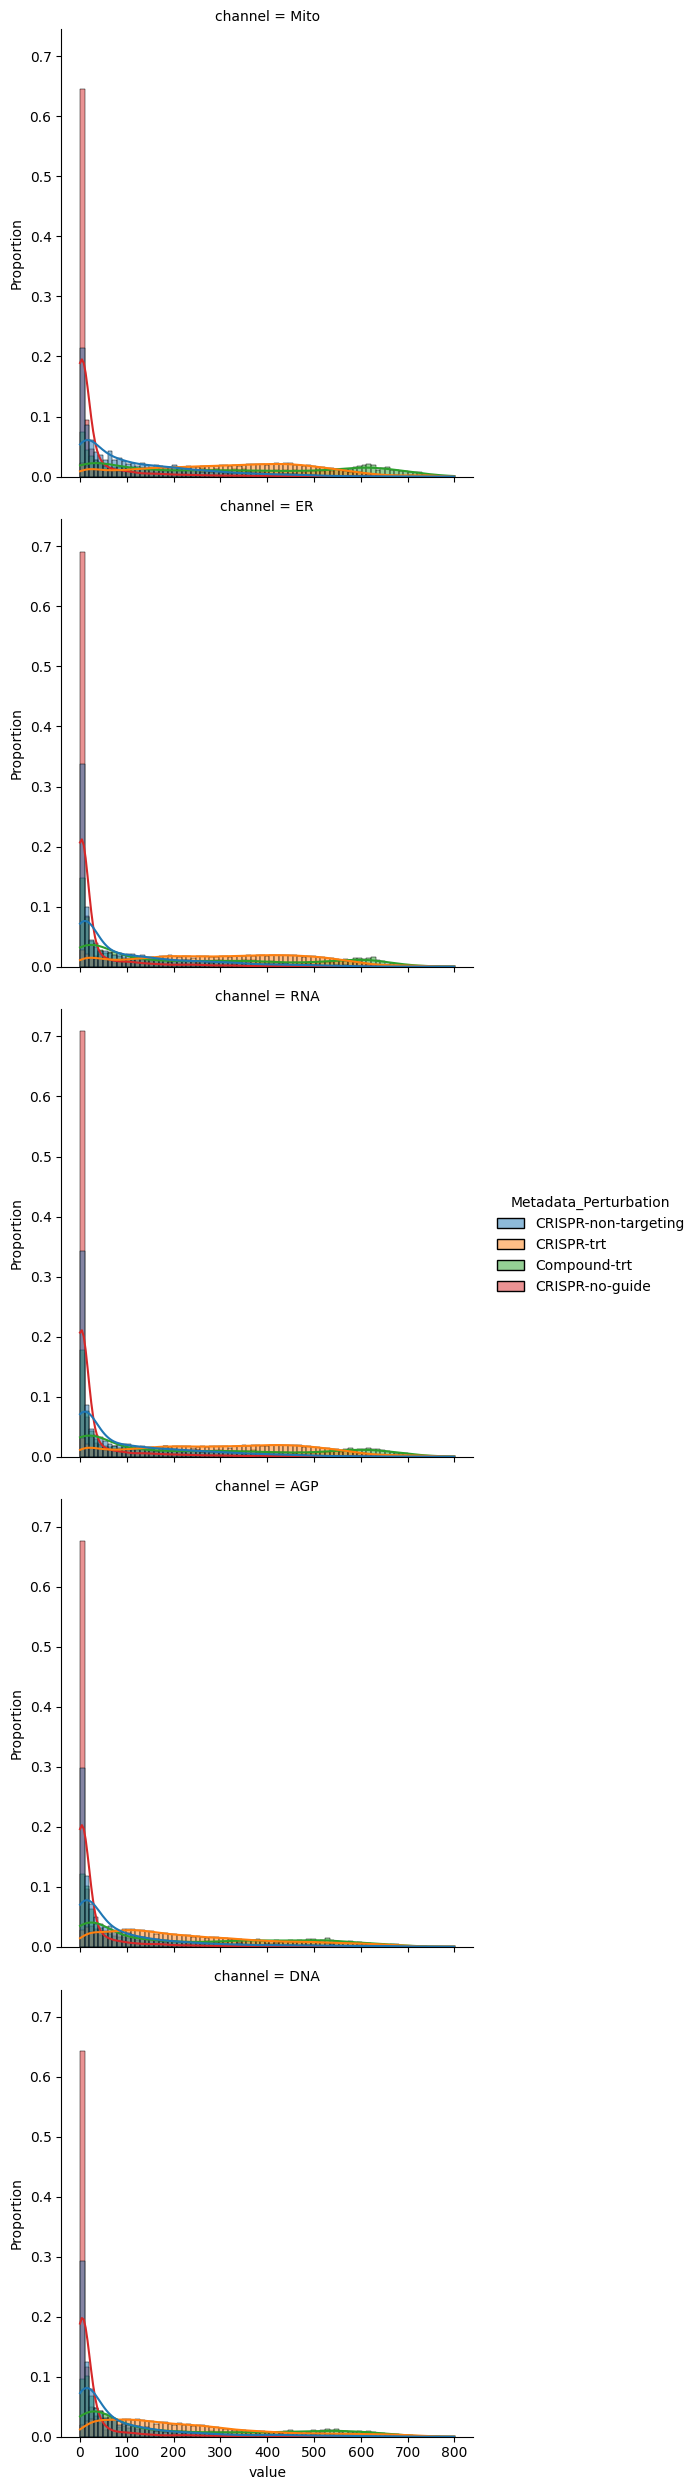

In [42]:
sns.displot(
    data=long_annotated_channel_sd2,
    x='value',
    row='channel',
    hue='Metadata_Perturbation',
    kde=True,
    common_norm=False,
    stat='proportion'
)

We define our thresholds based on the counts of features that are greater than 2 standard deviations from the mean.

* A positive label (representing morphological change) is given to counts above the point where the perturbation density surpasses 5 times the control density.
* A negative label (representing the absence of morphological change) is given to counts below the point where the control density surpasses the the perturbation` density.

In [43]:
def label_samples(sd_counts, sample_types, n_features, control_label = 'control', trt_label = 'trt'):

    control_kde, trt_kde = (
        gaussian_kde(
            dataset = sd_counts[sample_types == t],
            bw_method='scott'
        )
        for t in (control_label, trt_label)
    )

    range_array = np.arange(n_features)
    pt = np.where(control_kde(range_array)*5 < trt_kde(range_array))[0][0]
    nt = np.where(control_kde(range_array) < trt_kde(range_array)*1)[0][0]

    labels = pd.Series(data='Indeterminate', index=sd_counts.index)
    labels[sd_counts >= pt] = 'Positive'
    labels[sd_counts <= nt] = 'Negative'
    return labels

In [45]:
# Label all channels
labeled_channels = annotated_channel_sd2[['Metadata_Perturbation']].copy()
                                                   
for channel in channels:
    labeled_channels[channel] = label_samples(
        annotated_channel_sd2[channel],
        annotated_channel_sd2['Metadata_Perturbation'],
        exclusive_channels[channel].sum(),
        control_label='CRISPR-no-guide',
        trt_label='CRISPR-trt'
    )

labeled_channels

Metadata_Perturbation           Mito             ER   
Metadata_Plate                                                           
CP-CC9-R1-01   0    CRISPR-non-targeting  Indeterminate       Negative  \
               1              CRISPR-trt  Indeterminate  Indeterminate   
               2              CRISPR-trt       Positive       Positive   
               3              CRISPR-trt       Positive       Positive   
               4              CRISPR-trt       Positive       Positive   
...                                  ...            ...            ...   
CP-CC9-R8-02   379            CRISPR-trt  Indeterminate  Indeterminate   
               380            CRISPR-trt       Positive       Positive   
               381            CRISPR-trt  Indeterminate       Positive   
               382       CRISPR-no-guide       Negative  Indeterminate   
               383          Compound-trt       Positive       Positive   

                              RNA            AGP            DNA  
Metadata_Plate                                                   
CP-CC9-R1-01   0    Indeterminate       Positive       Positive  
               1         Negative       Positive       Negative  
               2         Positive       Positive       Positive  
               3         Positive       Positive       Positive  
               4         Positive       Positive       Positive  
...                           ...            ...            ...  
CP-CC9-R8-02   379       Positive       Negative  Indeterminate  
               380       Positive  Indeterminate  Indeterminate  
               381       Positive  Indeterminate  Indeterminate  
               382       Negative       Negative       Negative  
               383       Positive       Positive       Positive  

[56821 rows x 6 columns]

In [47]:
# Deliverable: per-channel labels on wells.
labeled_channels.to_csv('data/cpg0016/version_2023-07-17/well_channel_labels.csv')

#### Gene Channel Labels

In [49]:
annotated_labeled_channels = pd.concat(
    [
        labeled_channels.reset_index('Metadata_Plate', drop=True)[channels],
        annotated_profiles[
            annotated_profiles.columns[
                annotated_profiles.columns.str.startswith('Metadata')
            ]
        ]
    ],
    axis='columns'
)

In [50]:
annotated_labeled_channels

,Mito,ER,RNA,AGP,DNA,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Perturbation
0,Indeterminate,Negative,Indeterminate,Positive,Positive,source_13,CP-CC9-R1-01,A02,JCP2022_800002,non-targeting,NaN,CRISPR-non-targeting
1,Indeterminate,Indeterminate,Negative,Positive,Negative,source_13,CP-CC9-R1-01,A03,JCP2022_800573,ARHGEF7,8874,CRISPR-trt
2,Positive,Positive,Positive,Positive,Positive,source_13,CP-CC9-R1-01,A04,JCP2022_806794,ST13,6767,CRISPR-trt
3,Positive,Positive,Positive,Positive,Positive,source_13,CP-CC9-R1-01,A05,JCP2022_802800,GPHN,10243,CRISPR-trt
4,Positive,Positive,Positive,Positive,Positive,source_13,CP-CC9-R1-01,A06,JCP2022_802216,EXT2,2132,CRISPR-trt
...,...,...,...,...,...,...,...,...,...,...,...,...
379,Indeterminate,Indeterminate,Positive,Negative,Indeterminate,source_13,CP-CC9-R8-02,P20,JCP2022_801694,DCLRE1A,9937,CRISPR-trt
380,Positive,Positive,Positive,Indeterminate,Indeterminate,source_13,CP-CC9-R8-02,P21,JCP2022_804281,MS4A8,83661,CRISPR-trt
381,Indeterminate,Positive,Positive,Indeterminate,Indeterminate,source_13,CP-CC9-R8-02,P22,JCP2022_800983,CA7,766,CRISPR-trt
382,Negative,Indeterminate,Negative,Negative,Negative,source_13,CP-CC9-R8-02,P23,JCP2022_800001,no-guide,NaN,CRISPR-no-guide


In [52]:
# We need to do this for every channel and concatenate.

def get_majority_label(pd_series):
    vc = pd_series.value_counts()
    pls = vc.get('Positive', 0)
    nls = vc.get('Negative', 0)
    ils = vc.get('Indeterminate', 0)
    return 'Positive' if pls > nls + ils else ('Negative' if nls > pls + ils else 'Inteterminate')
    

# Grab only treatment
labeled_channel_trt = annotated_labeled_channels[annotated_labeled_channels['Metadata_Perturbation'] == 'CRISPR-trt']

# Group by gene
# get value counts for label
# unstack value counts
labeled_channel_genes = (
    labeled_channel_trt
    .groupby(['Metadata_Symbol', 'Metadata_NCBI_Gene_ID'])[channels]
    .apply(lambda df: df.apply(get_majority_label, axis='index'))
)
labeled_channel_genes


,,Mito,ER,RNA,AGP,DNA
Metadata_Symbol,Metadata_NCBI_Gene_ID,,,,,
A2M,2,Positive,Inteterminate,Inteterminate,Negative,Positive
A3GALT2,127550,Inteterminate,Positive,Positive,Positive,Positive
A4GALT,53947,Positive,Positive,Positive,Positive,Positive
A4GNT,51146,Positive,Inteterminate,Positive,Inteterminate,Inteterminate
AACS,65985,Positive,Positive,Inteterminate,Positive,Positive
...,...,...,...,...,...,...
ZSCAN32,54925,Inteterminate,Inteterminate,Inteterminate,Inteterminate,Inteterminate
ZSCAN4,201516,Positive,Positive,Positive,Positive,Positive
ZSCAN5A,79149,Positive,Positive,Positive,Positive,Positive


In [53]:
# Deliverable: per-channel gene labels
labeled_channel_genes.to_csv('data/cpg0016/version_2023-07-17/gene_channel_labels.csv')